In [7]:
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg


True
1
0
NVIDIA A100-PCIE-40GB


In [8]:
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 4999, "record_iters": False}
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
base_savedir = '/disk/xray0/tl3/outputs/large-scale-UQ/sampling/CRR'
save_dir = base_savedir + '/vars/'
savefig_dir = base_savedir + '/figs/'

img_name = 'M31'

# Load img
img_path = '/disk/xray0/tl3/repos/large-scale-UQ/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Load img
img_path = repo_dir + '/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img


INSTRUME                                                                         [astropy.io.fits.card]


In [9]:
# Load op from X Cai
op_mask = sio.loadmat(
    repo_dir + '/data/operators_masks/fourier_mask.mat'
)['Ma']

# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), (256,256), order='F').astype(bool)

# Define my torch types
myType = torch.float32
myComplexType = torch.complex64

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape)


dim = 256
phi = luq.operators.MaskedFourier_torch(
    dim=dim, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


# %%
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
f = luq.operators.RealProx_torch()


# %%
# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

sigma_training = 5
t_model = 5
dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(dir_name+exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# L_CRR = model.L.detach().cpu().squeeze().numpy()
# print(f"Lipschitz bound {L_CRR:.3f}")

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


In [15]:
# CRR parameters
# reg_params = [5e5, 1e6] # [250., 1e3, 5e3, 1e4, 5e4, 1e5]
theta_init = 1e2
mu = 20


print(((theta_init/mu) * model.cost(mu * torch.clone(x_init).reshape((1,1) + img.shape))).item())
print(g.fun(torch.clone(x_init)).item())

56.767005920410156
4761508.0


In [16]:

def solve_x(x_init, g, f, model, lmbd, mu, L_CRR, options): 
    # Prior parameters

    # Compute stepsize
    alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)

    # initialization
    x_hat = torch.clone(x_init)
    z = torch.clone(x_init)
    t = 1

    for it_2 in range(options['iter']):
        x_hat_old = torch.clone(x_hat)
        # grad = g.grad(z.squeeze()) +  lmbd * model(mu * z)
        x_hat = z - alpha *(
            g.grad(z) + lmbd * model(mu * z)
        )
        # Positivity constraint
        x_hat = f.prox(x_hat)
        # Positivity constraint
        # x = torch.clamp(x, 0, None)
        
        t_old = t 
        t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
        z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

        # relative change of norm for terminating
        res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

        if res < options['tol']:
            print("[GD] converged in %d iterations"%(it_2))
            break

        if it_2 % options['update_iter'] == 0:
            print(
                "[GD] %d out of %d iterations, tol = %f" %(            
                    it_2,
                    options['iter'],
                    res,
                )
            )

    return x_hat



In [12]:


# x_hat = solve_x(
#     x_init,
#     g,
#     f,
#     model,
#     lmbd=theta_init,
#     mu=mu,
#     L_CRR=L_CRR,
#     options=options
# )


[GD] 0 out of 15000 iterations, tol = 0.399494
[GD] 4999 out of 15000 iterations, tol = 0.000019
[GD] converged in 7958 iterations


In [13]:
# grad_theta = (-1/mu) * model.cost(x_hat/mu) 
# print(x_init.shape)
# print(x_hat.shape)

torch.Size([1, 256, 256])
torch.Size([1, 1, 256, 256])


In [17]:
# ((1/mu) * model.cost(mu * x_init)).shape
# print(g.fun(x_init).item())

In [18]:

def _fun(_x, model, mu, lmbd):
    return (lmbd / mu) * model.cost(mu * _x) + g.fun(_x)

def _fun_np(_x, model, mu, lmbd):
    return ((lmbd / mu) * model.cost(mu * _x) + g.fun(_x)).item()

In [93]:
x_init.shape

torch.Size([1, 256, 256])

In [82]:

np_x = np.copy(x)

out_iters = 10
theta = 1e3 # theta_init
potential = []
potential_prior = []
potential_likelihood = []
psnr_list = []

for it in range(out_iters):

    x_hat = solve_x(
        x_init,
        g,
        f,
        model,
        lmbd=theta,
        mu=mu,
        L_CRR=L_CRR,
        options=options
    )
    potential.append(_fun_np(x_hat, model, mu, theta))
    potential_prior.append(((theta/mu) * model.cost(mu * x_hat)).item())
    potential_likelihood.append(g.fun(x_hat).item())
    psnr_list.append(
        psnr(np_x, to_numpy(x_hat), data_range=np_x.max()-np_x.min())
    )
    print('Potential: ', potential[it], ', PSNR: ', psnr_list[it])
    print('Potential like: ', potential_likelihood[it], ', Potential prior: ', potential_prior[it])

    new_theta = (potential_likelihood[it] / potential_prior[it])

    # grad_theta = (-1/mu) * luq.utils.to_numpy(model.cost(x_hat/mu))
    # alpha_theta = 1e2/(L_CRR)
    # new_theta = theta - alpha_theta * grad_theta

    theta = new_theta
    print('theta: ', theta, ', it: ', it)
    

[GD] 0 out of 15000 iterations, tol = 0.370204
[GD] converged in 3706 iterations
Potential:  745.9313354492188 , PSNR:  54.49591490036422
Potential like:  3.7417924404144287 , Potential prior:  0.7421895265579224
theta:  5.041559206268872 , it:  0
[GD] 0 out of 15000 iterations, tol = 0.402857
[GD] converged in 21 iterations
Potential:  5.892630100250244 , PSNR:  35.06846646846958
Potential like:  0.0006101489416323602 , Potential prior:  1.1686899662017822
theta:  0.0005220793874147234 , it:  1
[GD] 0 out of 15000 iterations, tol = 0.403037
[GD] converged in 21 iterations
Potential:  0.0012093927944079041 , PSNR:  35.067955397080716
Potential like:  0.0005990730132907629 , Potential prior:  1.1690171957015991
theta:  0.0005124586836648047 , it:  2
[GD] 0 out of 15000 iterations, tol = 0.403037
[GD] converged in 21 iterations
Potential:  0.0011946687009185553 , PSNR:  35.06795561423822
Potential like:  0.0005955958040431142 , Potential prior:  1.1690170764923096
theta:  0.0005094842633

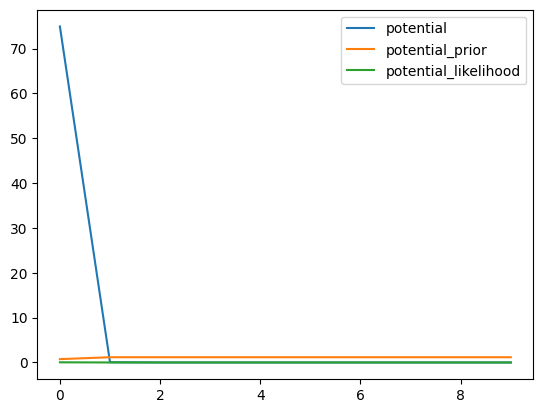

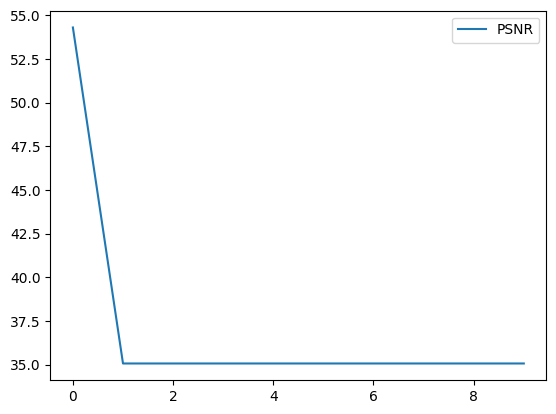

In [81]:
plt.figure()
plt.plot(potential, label='potential')
plt.plot(potential_prior, label='potential_prior')
plt.plot(potential_likelihood, label='potential_likelihood')
plt.legend()
plt.show()

plt.figure()
plt.plot(psnr_list, label='PSNR')
# plt.plot(potential_prior, label='potential_prior')
# plt.plot(potential_likelihood, label='potential_likelihood')
plt.legend()
plt.show()